# CG - Verfahren

Die Theorie folgt direkt dem [iFEM](https://github.com/JSchoeberl/iFEM/blob/master/iterative/conjugategradients.ipynb) Jupyter-Notebook, wobei wir für das Beispiel Dirichlet Randbedingungen implementieren.

Die Gradientenmethode ist eine Verbesserung der Richardson-Methode, da sie die spektralen Schranken nicht explizit benötigt. Das Chebyshev-Verfahren (nicht behandelt) ist eine Verbesserung des Richardson-Verfahrens, welches die Anzahl der Iterationen von $(\log \varepsilon^{-1}) \, \kappa$ auf $(\log \varepsilon^{-1}) \, \sqrt{\kappa}$ reduziert. Die Methode der konjugierten Gradienten kombiniert beide Vorteile.

Alle erwähnten Methoden benötigen eine Matrix-Vektor-Multiplikation mit der Systemmatrix $A$ und eine Anwendung des Vorkonditionierungs $C^{-1}$ pro Iteration, sowie einige Vektoraktualisierungen. Die Gradientenmethode und die konjugierte Gradientenmethode benötigen Skalarprodukte.


Die Idee hinter der CG-Methode ist die Minimierung der Ritz-Funktion

$$
\min_{x \in {\mathcal K}^n} \tfrac{1}{2} x^T A x - b^T x
$$

im Krylov-Raum

$$
{\mathcal K}^n = \operatorname{span} \{ C^{-1} b, C^{-1} A C^{-1} b, \ldots, (C^{-1} A)^{n-1} C^{-1} b \}.
$$

In jeder Iteration vergrößern wir den zu minimierenden Raum und berechnen den neuen Minimierer. Dies kann effizient durch die Berechnung einer orthogonalen Basis für ${\mathcal K}^n$ durchgeführt werden.

Da jede Polynom-Iteration (wie die Chebyshev-Methode) Schritte $x^n \in {\mathcal K}^n$ erzeugt, erhalten wir Fehlerschätzungen für die CG-Methode unmittelbar aus der Chebyshev-Methode.

## Lösen des Minimierungsproblems

Angenommen $V^n\subset {\mathbb R}^N$ sei ein $n$-dimensionaler Unterraum, welcher von den Basisvektoren $p_1, \ldots, p_n$ aufgespannt wird. Sei $P \in {\mathbb R}^{N \times n}$ gegeben durch die Basisvektoren $p^k$ als Spaltenvektoren. Wir lösen nun das Minimierungsproblem über dem Unterraum $V^n$

$$
\min_{x \in V^n} \tfrac{1}{2} x^T A x - b^T x.
$$

Da jedes $x \in V^n$ als $x = P y$ mit $y \in {\mathbb R}^n$ geschrieben werden kann, kann das Minimierungsproblem als

$$
\min_{y \in {\mathbb R}^n} \tfrac{1}{2} y^T P^T A P y - b^T P y.
$$

umgeschrieben werden. Die Lösung ist gegeben durch

$$
y = (P^T A P)^{-1} P^T b,
$$

welche durch Lösen eines niederdimensionalen ($n \times n$-dimensionalen) linearen Systems berechnet werden kann. Die original Lösung $x$ ist gegeben durch

$$
x = P (P^T A P)^{-1} P^T b.
$$

Wenn die Vektoren $p_i$ $A$-orthogonal sind (auch $A$-konjugiert genannt), d.h.

$$
{p_i}^T A p_j = 0 \quad \forall \, i \neq j,
$$

dann ist die Matrix $P^T A P$ diagonal, und das Minimierungsproblem kann sehr leicht gelöst werden:

$$
x = \sum_{i=1}^n \frac{{p_i}^T b}{{p_i}^T A p_i} p_i
$$

Vergrössert man den Raum $V^n$ auf $V^{n+1}$, indem man einen weiteren Vektor $p_{i+1}$ hinzufügt, der orthogonal zu allen bisherigen $p_1, \ldots , p_n$ ist, dann kann der Minimierer $x_{n+1}$ auf $V^{n+1}$ kostengünstig aus dem Minimierer $x^n$ auf $V^n$ aktualisiert werden:

$$
x_{n+1} = x_n + \frac{ p_{n+1}^T b}{ p_{n+1}^T A p_{n+1}} p_{n+1}.
$$

## Erweitern des Krylov-Raums

Nehmen wir an, wir haben den Krylov-Raum ${\mathcal K}^n$ und wir haben den Minimierer $x_n \in {\mathcal K}^n$ berechnet.

Dann ist der (negative) Gradient von $f(x) = \tfrac{1}{2} x^T A x - b^T x$ gegeben durch

$$
-\nabla f(x_n) = r_n = b - A x_n \; \bot_{{\mathbb R}^N} \; {\mathcal K}^n
$$

${\mathbb R}^N$-orthogonal zu ${\mathcal K}^n$. Es gilt daher

$$\langle b - A x_n, y\rangle = 0 \quad \forall\, y\in {\mathcal K}^n.$$

Wenn $r_n = 0$ ist, ist das Problem gelöst.

Da $r_n\ $ ${\mathbb R}^N$-orthogonal zu ${\mathcal K}^n$ ist, gilt für

$$
w_n := C^{-1} r_n  \qquad \text{mit} \qquad w_n \; \bot_C \; {\mathcal K}^n.
$$

Letzteres folgt aus

$$w_n \; \bot_C \; {\mathcal K}^n\qquad \Leftrightarrow\qquad \left< w_n, z \right>_C = \left< C w_n, z \right> = r_n^T z = 0\quad \text{für alle}\ z \in {\mathcal K}^n.$$

Da $x_n$ in ${\mathcal K}^n$ liegt und $w_n$ durch eine weitere Anwendung von $C^{-1}$ und $A$ erhalten wird, erhalten wir $w_n \in {\mathcal K}^{n+1}$. Zusammen mit der $C$-Orthogonalität haben wir

$$
{\mathcal K}^{n+1} = {\mathcal K}^n + \operatorname{span} \{ w_n \}
$$

Wir konstruieren nun eine $A$-orthogonale Basis mit Hilfe der Gram-Schmidt-Orthogonalisierung:

$$
p_{n+1} = w_n - \sum_{i=1}^n \frac{ \left<w_n, p_i\right>_A }{ \left< p_i, p_i \right>_A } p_i.
$$

Hier offenbart sich der Kern der CG-Methode. Für die Skalarprodukte im Zähler gilt

$$
\left< w_n, p_i \right>_A = \left< C^{-1} r_n, p_i \right>_A = r_n^T C^{-1} A p_i.
$$

Da $r^n \; \bot \; {\mathcal K}^n$ und $C^{-1} A p_i \in {\mathcal K}^{i+1}$ verschwinden diese Skalarprodukte für alle $i \leq n-1$. Es bleibt nur der letzte Term in der Summe übrig:

$$
p_{n+1} = w_n - \frac{ \left<w_n, p_n\right>_A }{ \left< p_n, p_n \right>_A } p_n.
$$

## Anwendung auf Modellproblem

Wir wenden das Verfahren auf das Modellproblem

$$\begin{split}
-\Delta u + 10\, u & = 1\quad x\in\Omega = [0,1]^2\\
u & = 0\quad x \in \partial\Omega\end{split}$$

an.

In [1]:
from ngsolve import *
from netgen.geom2d import unit_square
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
from myst_nb import glue

Diskretierung der schwachen Gleichung mit FEM 1. Ordnung:

In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))
fes = H1(mesh, order=1, dirichlet='bottom|right|top|left')
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx+10*u*v*dx).Assemble()
f = LinearForm(1*v*dx).Assemble()
gfu = GridFunction(fes)

Die Reduktion der Freiheitsgrade können wir in dem Fall direkt im Vorkonditionierer einbauen:

In [3]:
pre = a.mat.CreateSmoother(freedofs = fes.FreeDofs())

Damit folgt für das CG-Verfahren:

In [4]:
w = f.vec.CreateVector()
r = f.vec.CreateVector()
p = f.vec.CreateVector()
ap = f.vec.CreateVector()

r.data = f.vec
p.data = pre*r
wrn = InnerProduct(r,p)
err0 = sqrt(wrn)
errs = []
gfu.vec[:] = 0

maxit=200
tol=1e-8
its = 0
while True:
    ap.data = a.mat * p

    pap = InnerProduct(p, ap)
    wr = wrn
    alpha = wr / pap

    gfu.vec.data += alpha * p
    r.data -= alpha * ap
    w.data = pre*r

    wrn = InnerProduct(w, r)
    err = sqrt(wrn)
    errs.append(err)
    #print ("Iteration",it,"err=",err)
    if err < tol * err0 or its > 10000: break

    beta = wrn / wr

    p *= beta
    p.data += w
    its += 1
print ("needed", its, "iterations")

needed 28 iterations


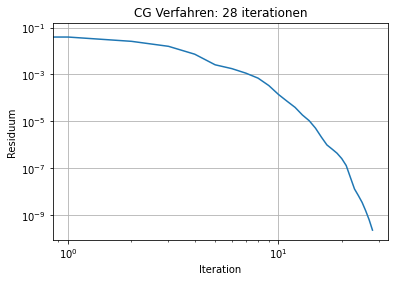

In [5]:
fig, ax = plt.subplots()
ax.loglog(errs)
ax.grid()
ax.set_title('CG Verfahren: '+str(its)+' iterationen')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residuum')
glue("FEM_CGVerfahren_fig", fig, display=False)

In [6]:
Draw(gfu,mesh,'u')

WebGuiWidget(value={'ngsolve_version': '6.2.2104-121-gee6902d12', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, '…

BaseWebGuiScene

## Vergleich CG - Gradienten Verfahren

In [7]:
import numpy as np
import matplotlib.pyplot as plt

Lineares Gleichungssystem im $\mathbb{R}^2$

$$\begin{pmatrix}3 & -2\\-2 & 4\end{pmatrix}\cdot\begin{pmatrix}x\\y\end{pmatrix} = \begin{pmatrix}7\\-10\end{pmatrix}$$

In [8]:
A = np.array([[3,-2],[-2,4]],dtype=np.float64)
b = np.array([7,-10],dtype=np.float64)

A muss symmetrisch und positiv definit sein.

In [9]:
np.linalg.eigvals(A)

array([1.43844719, 5.56155281])

Ritz Funktional ist gegeben durch

In [10]:
def f(x):
    return 0.5*x@(A@x)-b@x

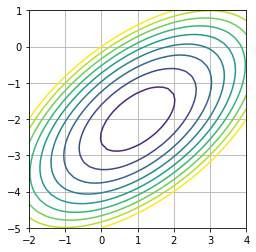

In [11]:
xp = np.linspace(-2,4,40)
yp = np.linspace(-5,1,40)
Xp,Yp = np.meshgrid(xp,yp)
plt.contour(Xp,Yp,np.array([[f(np.array([Xp[i,j],Yp[i,j]])) 
                             for j in range(40)] for i in range(40)]),
            np.linspace(-14,0,10))
plt.grid()
plt.gca().set_aspect(1)
plt.show()

Startwert für Gradienten und CG-Verfahren

In [12]:
x0 = np.array([-0.5,-5])
#x0 = np.array([0,-5])

### Gradienten Verfahren

In [13]:
# timeit ohne print verwenden.
#%%timeit
sol = np.array(x0,dtype=np.float64)
xG = [np.array(sol)]
r = np.array(b)-A@sol
err0 = np.linalg.norm(r)
its = 0
while True:
    p = A @ r
    err2 = np.dot(r,r)
    err = np.sqrt(err2)
    alpha = err2 / np.dot(r,p)
    
    print ("iteration", its, "res=", err)
    sol += alpha * r
    xG.append(np.array(sol))
    r -= alpha * p
    if np.sqrt(err2) < 1e-8 * err0 or its > 10000: break
    its += 1
print ("needed", its, "iterations")
xG = np.array(xG)

iteration 0 res= 9.12414379544733
iteration 1 res= 3.4148842275358424
iteration 2 res= 2.4835521654806128
iteration 3 res= 0.9295165999459604
iteration 4 res= 0.6760120726879713
iteration 5 res= 0.2530103663861413
iteration 6 res= 0.184007539189921
iteration 7 res= 0.06886831876113994
iteration 8 res= 0.050086050008101776
iteration 9 res= 0.018745656143383114
iteration 10 res= 0.013633204467914993
iteration 11 res= 0.005102485882728416
iteration 12 res= 0.003710898823802484
iteration 13 res= 0.0013888744135868948
iteration 14 res= 0.0010100904826086505
iteration 15 res= 0.00037804556074241916
iteration 16 res= 0.00027494222599448666
iteration 17 res= 0.00010290235358857979
iteration 18 res= 7.483807533714893e-05
iteration 19 res= 2.800957205600896e-05
iteration 20 res= 2.0370597858915606e-05
iteration 21 res= 7.624083409184791e-06
iteration 22 res= 5.544787933952574e-06
iteration 23 res= 2.0752422676781593e-06
iteration 24 res= 1.5092671037659337e-06
iteration 25 res= 5.648718984854972

### CG-Verfahren

In [14]:
# timeit ohne print verwenden.
#%%timeit
x = np.array(x0,dtype = np.float64)
r = np.array(b)-A@x
p = np.array(r)
wrn = r@p
xCG = [np.array(x)]
err0 = np.linalg.norm(r)
its = 0
while True:
    ap = A@p
    pap = p@ap
    wr = wrn
    alpha = wr/pap
    x += alpha*p
    xCG.append(np.array(x))
    r -= alpha*ap
    w = np.array(r)
    wrn = w@r
    err = np.sqrt(wrn)
    print ("iteration", its, "res=", err)
    beta = wrn/wr
    p *= beta
    p += w
    if np.sqrt(err) < 1e-8 * err0 or its > 10000: break
    its += 1
print ("needed", its, "iterations")
xCG = np.array(xCG)

iteration 0 res= 3.4148842275358424
iteration 1 res= 6.661338147750939e-16
needed 1 iterations


Aufgrund der Dimension des Problems, ist die Lösung in zwei Schritten exakt berechnet.

### Vergleich

In [15]:
xCG

array([[-0.5       , -5.        ],
       [-0.8245614 , -3.05263158],
       [ 1.        , -2.        ]])

In [16]:
xG

array([[-0.5       , -5.        ],
       [-0.8245614 , -3.05263158],
       [ 0.59170654, -2.81658692],
       [ 0.50336234, -2.28652173],
       [ 0.8888643 , -2.2222714 ],
       [ 0.86481739, -2.07798997],
       [ 0.96974935, -2.06050131],
       [ 0.96320388, -2.02122853],
       [ 0.9917659 , -2.01646819],
       [ 0.98998426, -2.00577831],
       [ 0.99775871, -2.00448257],
       [ 0.99727376, -2.00157283],
       [ 0.99938993, -2.00122014],
       [ 0.99925793, -2.00042812],
       [ 0.99983394, -2.00033212],
       [ 0.99979801, -2.00011653],
       [ 0.9999548 , -2.0000904 ],
       [ 0.99994502, -2.00003172],
       [ 0.9999877 , -2.00002461],
       [ 0.99998503, -2.00000863],
       [ 0.99999665, -2.0000067 ],
       [ 0.99999593, -2.00000235],
       [ 0.99999909, -2.00000182],
       [ 0.99999889, -2.00000064],
       [ 0.99999975, -2.0000005 ],
       [ 0.9999997 , -2.00000017],
       [ 0.99999993, -2.00000014],
       [ 0.99999992, -2.00000005],
       [ 0.99999998,

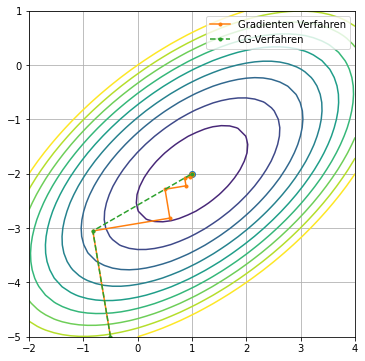

In [17]:
plt.figure(figsize=(6,6))
plt.contour(Xp,Yp,np.array([[f(np.array([Xp[i,j],Yp[i,j]])) for j in range(40)] for i in range(40)]),
            np.linspace(-14,0,10))
plt.plot(*x,'o')
plt.plot(*xG.T,'.-',label='Gradienten Verfahren')
plt.plot(*xCG.T,'.--',label='CG-Verfahren')
plt.gca().set_aspect(1)
plt.legend()
plt.grid()
plt.show()